In [1]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv("cleaned_logger_keystrokelog.csv")

# Convert timestamp if not already
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Optional: create session ID using large time gaps (e.g. >5 minutes)
df = df.sort_values(['user_id', 'timestamp'])
df['session_id'] = (df['timestamp'].diff() > pd.Timedelta(minutes=5)).cumsum()

# Group by user and session
group_cols = ['user_id', 'session_id']
timing_features = ['dwell_time', 'flight_time', 'up_down_time']

# Aggregate functions
agg_funcs = {
    'dwell_time': ['mean', 'std', 'min', 'max'],
    'flight_time': ['mean', 'std', 'min', 'max'],
    'up_down_time': ['mean', 'std', 'min', 'max'],
    'timestamp': ['min', 'max'],
    'id': 'count'
}

# Generate feature table
features_df = df.groupby(group_cols).agg(agg_funcs)
features_df.columns = ['_'.join(col).strip() for col in features_df.columns.values]
features_df = features_df.reset_index()

# Compute session duration in seconds
features_df['session_duration_sec'] = (features_df['timestamp_max'] - features_df['timestamp_min']).dt.total_seconds()

# Compute typing speed: keystrokes per minute
features_df['keystrokes_per_min'] = features_df['id_count'] / (features_df['session_duration_sec'] / 60)

# Optional ratios
features_df['dwell_to_flight_ratio'] = features_df['dwell_time_mean'] / (features_df['flight_time_mean'] + 1e-6)

# Clean up
features_df = features_df.drop(columns=['timestamp_min', 'timestamp_max'])

# Preview engineered features
print(features_df.head())

# Save for modeling
features_df.to_csv("keystroke_user_features.csv", index=False)
print("\n✅ Feature engineering complete. Output saved as 'keystroke_user_features.csv'")


   user_id  session_id  dwell_time_mean  dwell_time_std  dwell_time_min  \
0      1.0           0         0.118631        0.047902        0.084759   
1      1.0           1         0.092717        0.070147        0.004025   
2      1.0           2         0.108900        0.078648        0.048295   
3      1.0           3         0.183997        0.403442        0.038320   
4      1.0           4         0.108993        0.088575        0.049606   

   dwell_time_max  flight_time_mean  flight_time_std  flight_time_min  \
0        0.152503          0.894101         1.264450         0.000000   
1        0.324357          0.362370         0.598051        -0.206853   
2        0.463356          1.424489         4.426462        -0.379879   
3        2.241450          0.445430         1.375062        -1.887344   
4        0.489255          0.469935         1.356182        -0.419991   

   flight_time_max  up_down_time_mean  up_down_time_std  up_down_time_min  \
0         1.788202           0.89

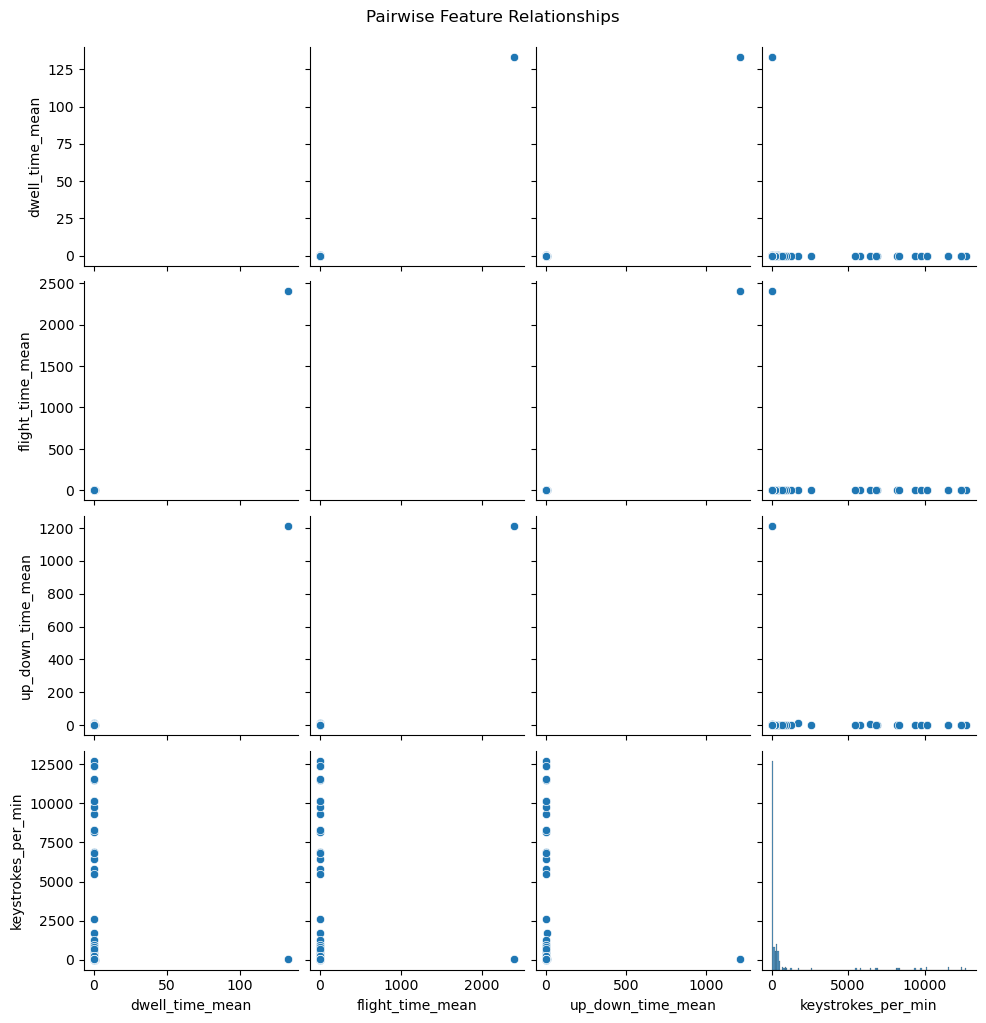

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(features_df[['dwell_time_mean', 'flight_time_mean', 'up_down_time_mean', 'keystrokes_per_min']])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()


In [4]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 32.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 34.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [5]:
from sklearn.decomposition import PCA


In [6]:
from sklearn.decomposition import PCA

X = features_df[['dwell_time_mean', 'flight_time_mean', 'up_down_time_mean', 'keystrokes_per_min']]
X = X.fillna(0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['user_id'], cmap='tab10', alpha=0.7)
plt.title("User Behavior Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [7]:
# Check for infinity values
print(np.isinf(X).sum())

# Check for very large values
print("Max values in each column:")
print(X.max())


dwell_time_mean       0
flight_time_mean      0
up_down_time_mean     0
keystrokes_per_min    2
dtype: int64
Max values in each column:
dwell_time_mean        133.270270
flight_time_mean      2399.270270
up_down_time_mean     1211.783784
keystrokes_per_min            inf
dtype: float64


In [8]:
# Replace inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally: cap the values to a reasonable upper bound (e.g., 500 strokes/min)
X['keystrokes_per_min'] = X['keystrokes_per_min'].clip(upper=500)

# Drop remaining rows with NaN
X.dropna(inplace=True)

# Check again
print(X.isnull().sum())
print(X.describe())


dwell_time_mean       0
flight_time_mean      0
up_down_time_mean     0
keystrokes_per_min    0
dtype: int64
       dwell_time_mean  flight_time_mean  up_down_time_mean  \
count       240.000000        240.000000         240.000000   
mean          0.657902         10.416643           5.425893   
std           8.596159        154.848404          78.201292   
min           0.002383          0.000000           0.000000   
25%           0.078545          0.113984           0.137274   
50%           0.095388          0.172676           0.187485   
75%           0.122416          0.276762           0.280175   
max         133.270270       2399.270270        1211.783784   

       keystrokes_per_min  
count          240.000000  
mean           155.639211  
std            180.271634  
min              2.380594  
25%             20.670663  
50%             53.946018  
75%            315.597262  
max            500.000000  


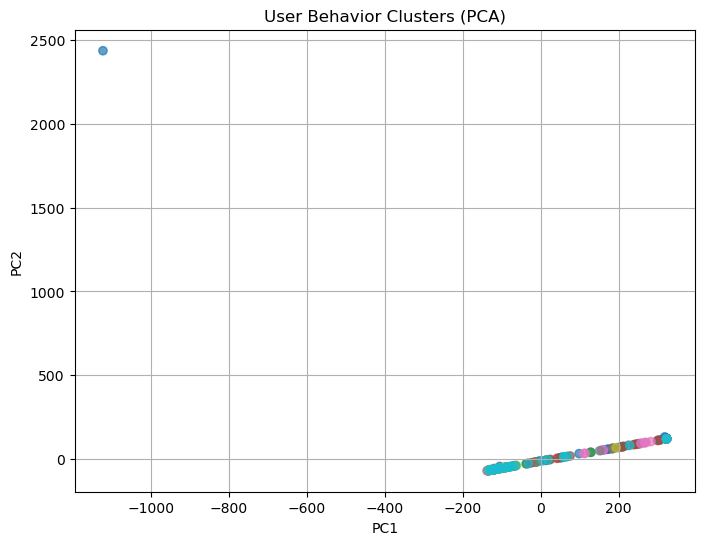

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['user_id'][:len(X_pca)], cmap='tab10', alpha=0.7)
plt.title("User Behavior Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


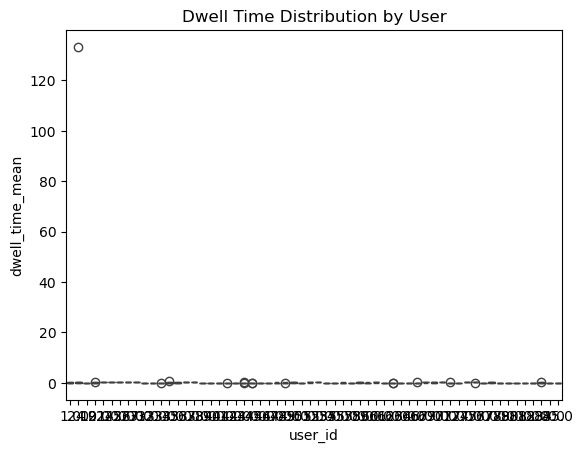

In [10]:
import seaborn as sns

sns.boxplot(x='user_id', y='dwell_time_mean', data=features_df)
plt.title("Dwell Time Distribution by User")
plt.show()


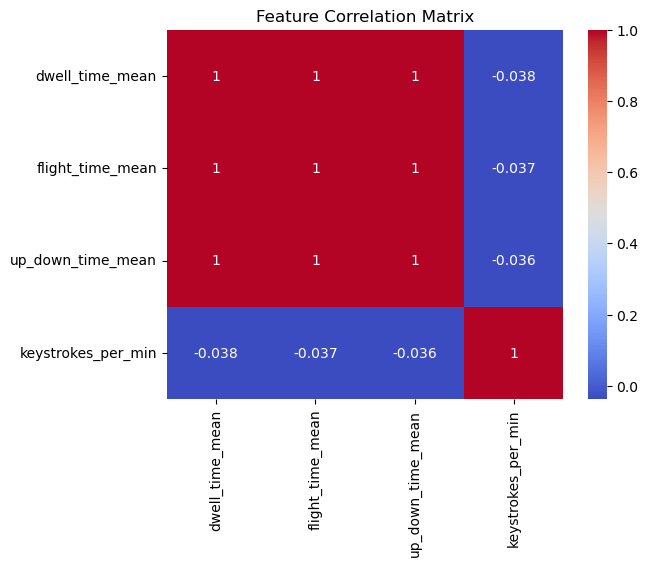

In [11]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [12]:
user_profiles = features_df.groupby('user_id').mean().reset_index()
print(user_profiles.head())


   user_id  session_id  dwell_time_mean  dwell_time_std  dwell_time_min  \
0      1.0         6.5         0.127098        0.123331        0.058003   
1      2.0        29.0         4.177238        3.280570        0.026537   
2      4.0        45.0         0.107755        0.040501        0.000000   
3     19.0        47.5         0.121814        0.099141        0.014500   
4     21.0        50.0         0.127460        0.156694        0.000000   

   dwell_time_max  flight_time_mean  flight_time_std  flight_time_min  \
0        0.559805          1.707310         3.891293        -0.398561   
1       14.387174         73.778175       181.651375        -0.057199   
2        0.170000          0.100408         0.186897         0.000000   
3        0.607833          0.181218         0.527431         0.000000   
4        0.820000          0.275968         0.465891         0.000000   

   flight_time_max  up_down_time_mean  up_down_time_std  up_down_time_min  \
0        11.971713           1.70

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select features for clustering
X = features_df[['dwell_time_mean', 'flight_time_mean', 'up_down_time_mean', 'keystrokes_per_min']].copy()

# Clean any remaining NaNs or infs
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster column back to features_df for analysis
features_df = features_df.loc[X.index]
features_df['cluster'] = X['cluster']


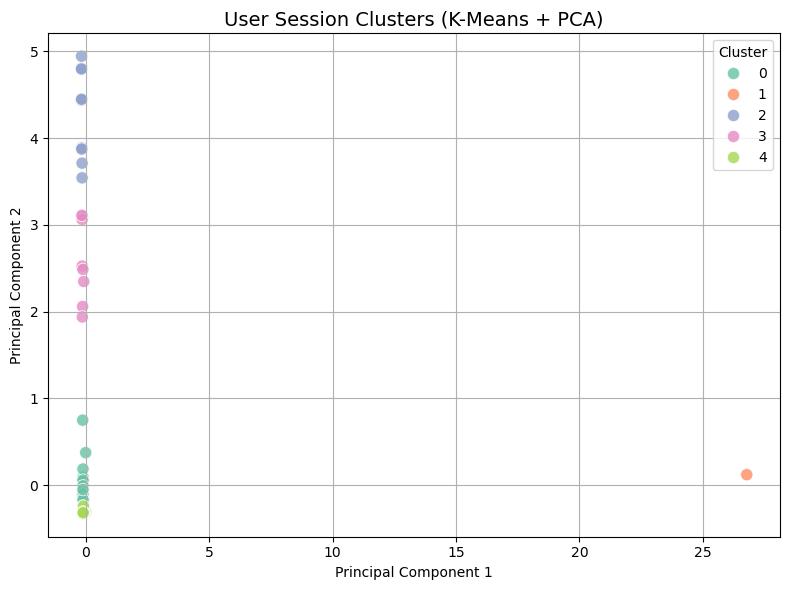

In [14]:
# Plot clusters using first two PCA components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X['cluster'], palette='Set2', s=80, alpha=0.8)
plt.title("User Session Clusters (K-Means + PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()

# Export plot
plt.savefig("session_clusters.png", dpi=300)
plt.show()


/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_90375/1853581411.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='cluster', y='dwell_time_mean', palette='Set2')


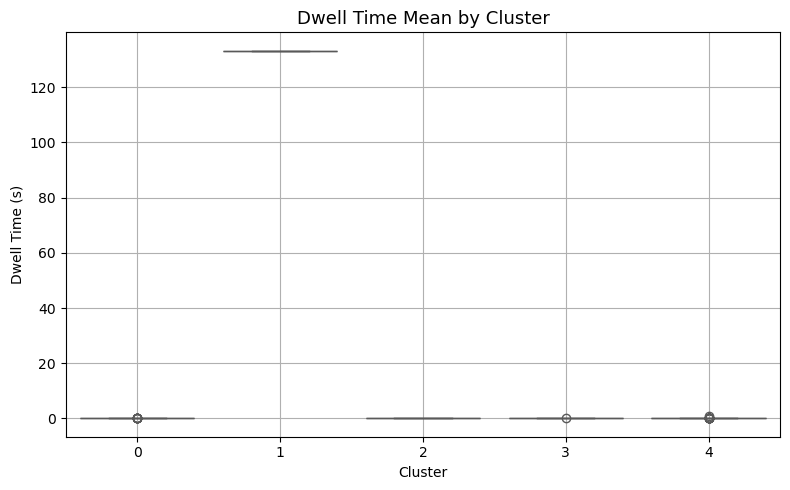

In [15]:
# Boxplot of dwell time mean by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=features_df, x='cluster', y='dwell_time_mean', palette='Set2')
plt.title("Dwell Time Mean by Cluster", fontsize=13)
plt.xlabel("Cluster")
plt.ylabel("Dwell Time (s)")
plt.grid(True)
plt.tight_layout()
plt.savefig("dwell_time_by_cluster.png", dpi=300)
plt.show()


/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_90375/2205115268.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


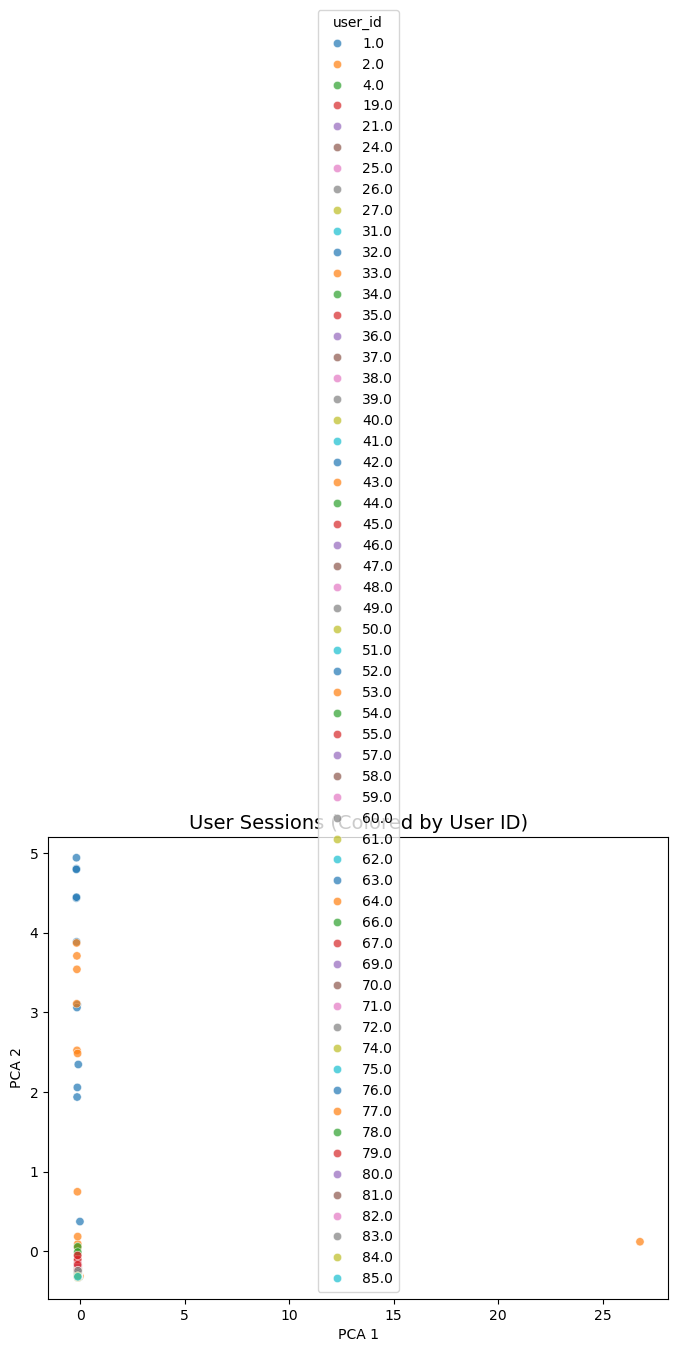

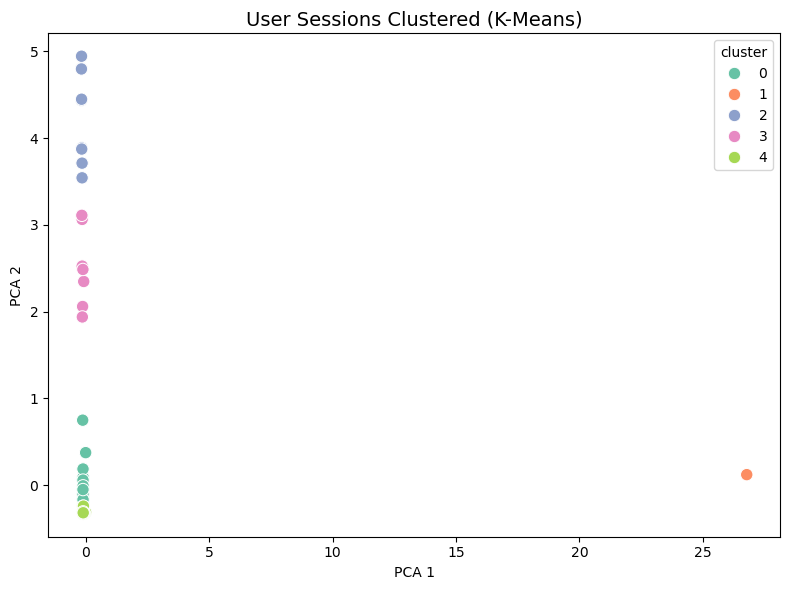

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select and clean features
features = ['dwell_time_mean', 'flight_time_mean', 'up_down_time_mean', 'keystrokes_per_min']
X = features_df[features].copy()
X = X.replace([np.inf, -np.inf], np.nan).dropna()
features_df = features_df.loc[X.index]  # sync indices

# Scale for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize: cluster vs user_id
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=features_df['user_id'], palette='tab10', alpha=0.7)
plt.title("User Sessions (Colored by User ID)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.savefig("pca_by_user.png", dpi=300)
plt.savefig("pca_by_user.pdf")
plt.show()

# Visualize: cluster vs cluster label
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=features_df['cluster'], palette='Set2', s=80)
plt.title("User Sessions Clustered (K-Means)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.savefig("pca_by_cluster.png", dpi=300)
plt.savefig("pca_by_cluster.pdf")
plt.show()


/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_90375/1033348961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='cluster', y=feature, palette='Set2')


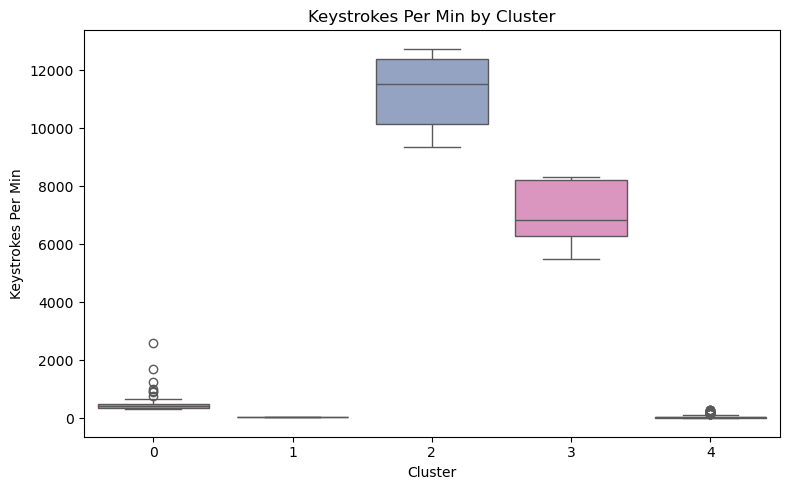

/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_90375/1033348961.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='cluster', y=feature, palette='Set2')


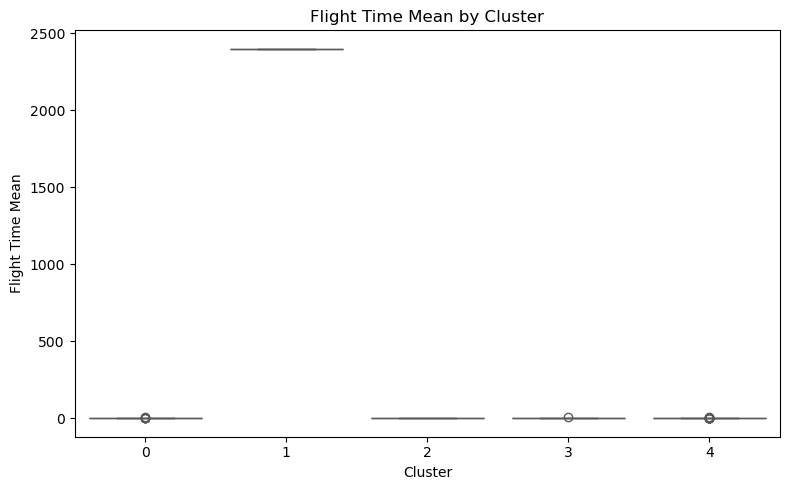

In [17]:
def save_boxplot(feature, filename):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=features_df, x='cluster', y=feature, palette='Set2')
    plt.title(f"{feature.replace('_', ' ').title()} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)
    plt.savefig(f"{filename}.pdf")
    plt.show()

# Call for any feature:
save_boxplot('keystrokes_per_min', 'keystrokes_by_cluster')
save_boxplot('flight_time_mean', 'flight_time_by_cluster')


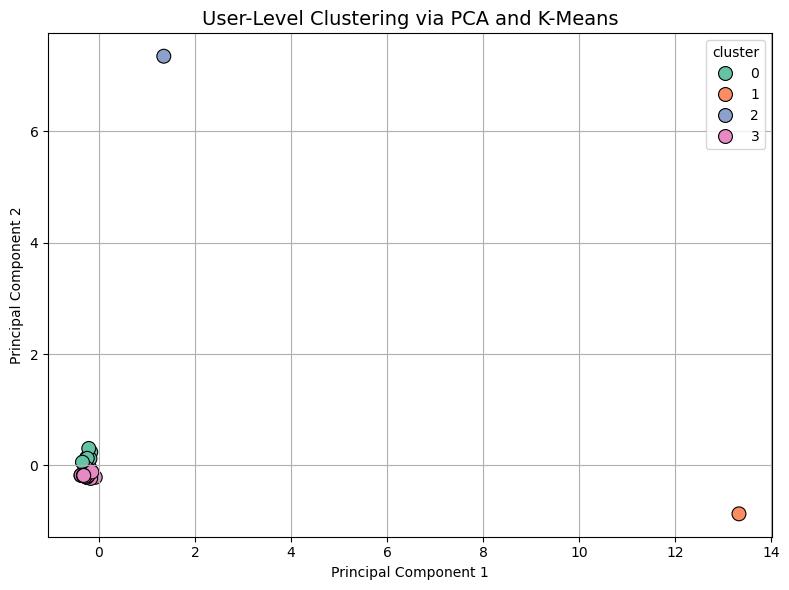

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Define relevant features
behavioral_features = ['dwell_time_mean', 'flight_time_mean', 'up_down_time_mean', 'keystrokes_per_min']

# Step 1: Aggregate per user
user_df = features_df.groupby('user_id')[behavioral_features].mean().reset_index()

# Step 2: Scale data
scaler = StandardScaler()
X_user = scaler.fit_transform(user_df[behavioral_features])

# Step 3: Run K-Means clustering (you can change n_clusters as needed)
kmeans = KMeans(n_clusters=4, random_state=42)
user_df['cluster'] = kmeans.fit_predict(X_user)

# Step 4: PCA for 2D projection
pca = PCA(n_components=2)
X_user_pca = pca.fit_transform(X_user)

# Step 5: Plot and export
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_user_pca[:, 0], y=X_user_pca[:, 1], hue=user_df['cluster'], palette='Set2', s=100, edgecolor='black')
plt.title("User-Level Clustering via PCA and K-Means", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("user_level_clusters.png", dpi=300)
plt.savefig("user_level_clusters.pdf")
plt.show()


In [19]:
# Cluster means
user_cluster_summary = user_df.groupby('cluster')[behavioral_features].mean()
print(user_cluster_summary)


         dwell_time_mean  flight_time_mean  up_down_time_mean  \
cluster                                                         
0               0.086750          0.148634           0.142927   
1               4.304298         76.048918          38.616378   
2               0.122902          1.820655           1.820655   
3               0.101642          0.249516           0.237453   

         keystrokes_per_min  
cluster                      
0                361.414656  
1               1781.016015  
2               8203.166358  
3                 72.319144  


In [21]:
import pandas as pd
import numpy as np

# Step 1: Load and clean
mouse_df = pd.read_csv("logger_mouseactionlog_modified.csv")
mouse_df = mouse_df.dropna()
mouse_df['timestamp'] = pd.to_datetime(mouse_df['timestamp'], format='mixed', errors='coerce')


/var/folders/xn/3p4bls9951b26kzwyk7s2_g40000gp/T/ipykernel_90375/842403621.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mouse_df = pd.read_csv("logger_mouseactionlog_modified.csv")


In [25]:
# Ensure timestamp is parsed correctly
mouse_df['timestamp'] = pd.to_datetime(mouse_df['timestamp'], errors='coerce')

# Drop rows where timestamp parsing failed
mouse_df = mouse_df.dropna(subset=['timestamp'])


In [27]:
# Safely split coordinates into x and y
coords_split = mouse_df['coordinates'].str.split(",", expand=True)
coords_split = coords_split[coords_split.columns[:2]]  # Use only first 2 columns
coords_split.columns = ['x', 'y']

# Drop rows with invalid or missing coordinates
valid_coords_mask = coords_split['x'].notna() & coords_split['y'].notna()
mouse_df = mouse_df[valid_coords_mask]
coords_split = coords_split[valid_coords_mask]

# Convert to float
mouse_df['x'] = coords_split['x'].astype(float)
mouse_df['y'] = coords_split['y'].astype(float)

# Repeat for delta
delta_split = mouse_df['delta'].str.split(",", expand=True)
delta_split = delta_split[delta_split.columns[:2]]
delta_split.columns = ['delta_x', 'delta_y']

# Drop invalid delta rows
valid_delta_mask = delta_split['delta_x'].notna() & delta_split['delta_y'].notna()
mouse_df = mouse_df[valid_delta_mask]
delta_split = delta_split[valid_delta_mask]

# Convert to float
mouse_df['delta_x'] = delta_split['delta_x'].astype(float)
mouse_df['delta_y'] = delta_split['delta_y'].astype(float)


In [30]:
def safe_split_xy(series):
    # Split by comma
    split_df = series.str.split(",", expand=True)
    
    # Only keep rows where exactly two columns result from the split
    valid_rows = split_df.shape[1] >= 2
    split_df = split_df.loc[:, :1]  # Keep only the first two columns
    split_df.columns = ['x', 'y']
    
    # Drop rows with missing or malformed values
    split_df = split_df.dropna()
    try:
        split_df['x'] = pd.to_numeric(split_df['x'], errors='coerce')
        split_df['y'] = pd.to_numeric(split_df['y'], errors='coerce')
    except Exception:
        pass
    
    return split_df.dropna()

# Parse coordinates
coords_parsed = safe_split_xy(mouse_df['coordinates'])
mouse_df = mouse_df.loc[coords_parsed.index].copy()
mouse_df[['x', 'y']] = coords_parsed[['x', 'y']]

# Parse delta
delta_parsed = safe_split_xy(mouse_df['delta'])
mouse_df = mouse_df.loc[delta_parsed.index].copy()
mouse_df[['delta_x', 'delta_y']] = delta_parsed[['x', 'y']]


In [31]:
# Save the cleaned mouse dataset to a CSV file
mouse_df.to_csv("cleaned_logger_mouseactionlog.csv", index=False)

print("✅ Cleaned mouse action dataset saved as 'cleaned_logger_mouseactionlog.csv'")


✅ Cleaned mouse action dataset saved as 'cleaned_logger_mouseactionlog.csv'


In [32]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
mouse_df = pd.read_csv("cleaned_logger_mouseactionlog.csv")

# Convert timestamp to datetime (safety check)
mouse_df['timestamp'] = pd.to_datetime(mouse_df['timestamp'])

# Sort and assign session IDs based on 10-minute inactivity
mouse_df = mouse_df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
mouse_df['time_diff'] = mouse_df.groupby('user_id')['timestamp'].diff().dt.total_seconds()
mouse_df['session_id'] = (mouse_df['time_diff'] > 600).cumsum()

# Ensure numeric values
mouse_df['distance'] = pd.to_numeric(mouse_df['distance'], errors='coerce')
mouse_df['speed'] = pd.to_numeric(mouse_df['speed'], errors='coerce')

# Feature engineering per session
session_features = mouse_df.groupby(['user_id', 'session_id']).agg({
    'distance': ['mean', 'sum'],
    'speed': ['mean', 'max'],
    'action': lambda x: (x == 'click').sum(),
    'timestamp': ['min', 'max'],
    'id': 'count'
}).reset_index()

# Flatten column names
session_features.columns = ['user_id', 'session_id',
                            'distance_mean', 'distance_sum',
                            'speed_mean', 'speed_max',
                            'click_count', 'start_time', 'end_time',
                            'action_count']

# Calculate session duration in seconds
session_features['session_duration_sec'] = (pd.to_datetime(session_features['end_time']) - 
                                            pd.to_datetime(session_features['start_time'])).dt.total_seconds()

# Save to CSV
session_features.to_csv("mouse_session_features.csv", index=False)

# Display preview
print("✅ Mouse session-level features extracted and saved as 'mouse_session_features.csv'")
session_features.head()


✅ Mouse session-level features extracted and saved as 'mouse_session_features.csv'


,user_id,session_id,distance_mean,distance_sum,speed_mean,speed_max,click_count,start_time,end_time,action_count,session_duration_sec
0,2.0,0,0.0,0.0,0.0,0.0,18,2025-03-21 14:05:31.336000+00:00,2025-03-21 14:10:13.183000+00:00,18,281.8470
1,2.0,1,0.0,0.0,0.0,0.0,5,2025-03-21 14:23:33.156000+00:00,2025-03-21 14:24:15.272000+00:00,5,42.1160
2,2.0,2,0.0,0.0,0.0,0.0,16,2025-03-21 14:34:24.413400+00:00,2025-03-21 14:54:19.148000+00:00,16,1194.7346
3,2.0,3,0.0,0.0,0.0,0.0,15,2025-03-22 02:55:36.903000+00:00,2025-03-22 02:57:14.703000+00:00,15,97.8000
4,2.0,4,0.0,0.0,0.0,0.0,20,2025-03-22 03:53:29.275000+00:00,2025-03-22 03:55:20.723000+00:00,20,111.4480


In [33]:
# Load session-level features
mouse_sessions = pd.read_csv("mouse_session_features.csv")

# User-level aggregation
mouse_user_features = mouse_sessions.groupby('user_id').agg({
    'distance_mean': ['mean', 'std'],
    'distance_sum': 'sum',
    'speed_mean': ['mean', 'std'],
    'speed_max': 'max',
    'click_count': ['sum', 'mean'],
    'action_count': 'sum',
    'session_duration_sec': ['sum', 'mean', 'std']
}).reset_index()

# Flatten column names
mouse_user_features.columns = ['user_id',
    'distance_mean_mean', 'distance_mean_std',
    'distance_sum_total',
    'speed_mean_mean', 'speed_mean_std',
    'speed_max_max',
    'click_count_total', 'click_count_mean',
    'action_count_total',
    'session_duration_sum', 'session_duration_mean', 'session_duration_std'
]

# Save user-level features
mouse_user_features.to_csv("mouse_user_features.csv", index=False)

# Display preview
print("✅ Mouse user-level features extracted and saved as 'mouse_user_features.csv'")
mouse_user_features.head()


✅ Mouse user-level features extracted and saved as 'mouse_user_features.csv'


,user_id,distance_mean_mean,distance_mean_std,distance_sum_total,speed_mean_mean,speed_mean_std,speed_max_max,click_count_total,click_count_mean,action_count_total,session_duration_sum,session_duration_mean,session_duration_std
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,176,9.263158,176,4180.4376,220.023032,387.888018
1,4.0,0.0,NaN,0.0,0.0,NaN,0.0,5,5.000000,5,45.1000,45.100000,NaN
2,19.0,0.0,0.0,0.0,0.0,0.0,0.0,82,13.666667,82,300.6080,50.101333,57.521326
3,21.0,0.0,NaN,0.0,0.0,NaN,0.0,3,3.000000,3,21.7980,21.798000,NaN
4,24.0,0.0,0.0,0.0,0.0,0.0,0.0,32,10.666667,32,70.8140,23.604667,13.075519


In [34]:
import pandas as pd

# Load the cleaned keystroke data
keystroke_df = pd.read_csv("cleaned_logger_keystrokelog.csv")

# Ensure timestamp is datetime
keystroke_df['timestamp'] = pd.to_datetime(keystroke_df['timestamp'])

# Assign session_id based on 10-minute inactivity
keystroke_df = keystroke_df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
keystroke_df['time_diff'] = keystroke_df.groupby('user_id')['timestamp'].diff().dt.total_seconds()
keystroke_df['session_id'] = (keystroke_df['time_diff'] > 600).cumsum()

# Feature engineering
user_features = keystroke_df.groupby(['user_id', 'session_id']).agg({
    'dwell_time': ['mean', 'std', 'min', 'max'],
    'flight_time': ['mean', 'std', 'min', 'max'],
    'up_down_time': ['mean', 'std', 'min', 'max'],
    'id': 'count',
    'timestamp': ['min', 'max']
})

# Flatten columns
user_features.columns = ['_'.join(col).strip() for col in user_features.columns.values]
user_features = user_features.reset_index()

# Session duration
user_features['session_duration_sec'] = (user_features['timestamp_max'] - user_features['timestamp_min']).dt.total_seconds()
user_features['keystrokes_per_min'] = user_features['id_count'] / (user_features['session_duration_sec'] / 60).replace(0, 1)
user_features['dwell_to_flight_ratio'] = user_features['dwell_time_mean'] / user_features['flight_time_mean'].replace(0, 1)

# Aggregate at user-level
keystroke_user_features = user_features.groupby('user_id').mean(numeric_only=True).reset_index()

# Save the features
keystroke_user_features.to_csv("keystroke_user_features.csv", index=False)

print("✅ Keystroke user features regenerated and saved.")


✅ Keystroke user features regenerated and saved.


In [36]:
keystroke_user_df = pd.read_csv("./keystroke_user_features.csv")


In [37]:
import pandas as pd

# Load mouse features
mouse_user_df = pd.read_csv("./mouse_user_features.csv")

# Merge on 'user_id'
combined_user_df = pd.merge(keystroke_user_df, mouse_user_df, on="user_id", suffixes=('_key', '_mouse'))

# Save the combined file
combined_user_df.to_csv("combined_user_features.csv", index=False)

# Preview
print("✅ Merged user-level features:")
print(combined_user_df.head())


✅ Merged user-level features:
   user_id  session_id  dwell_time_mean  dwell_time_std  dwell_time_min  \
0      2.0        25.5         4.894141        3.860710        0.024311   
1      4.0        39.0         0.107755        0.040501        0.000000   
2     19.0        41.5         0.121814        0.099141        0.014500   
3     21.0        44.0         0.127460        0.156694        0.000000   
4     24.0        45.0         0.148572        0.136534        0.000000   

   dwell_time_max  flight_time_mean  flight_time_std  flight_time_min  \
0       16.881562         86.543326       214.369541        -0.067413   
1        0.170000          0.100408         0.186897         0.000000   
2        0.607833          0.181218         0.527431         0.000000   
3        0.820000          0.275968         0.465891         0.000000   
4        0.705000          0.250549         0.585293         0.000000   

   flight_time_max  ...  distance_sum_total  speed_mean_mean  speed_mean_std  \


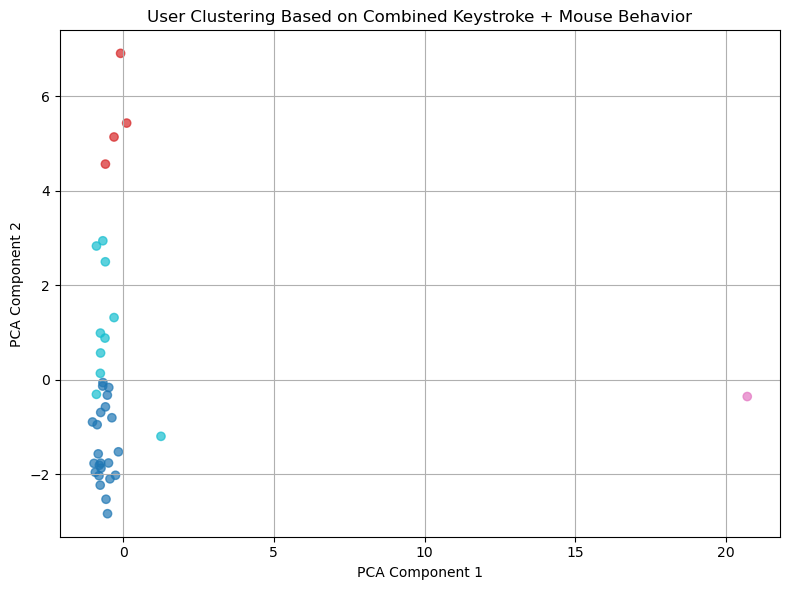

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load combined features
combined_user_df = pd.read_csv("combined_user_features.csv")

# Drop non-numeric or identifier columns
X = combined_user_df.drop(columns=["user_id"])

# Handle missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
combined_user_df = combined_user_df.loc[X.index]  # align index
combined_user_df["cluster"] = kmeans.fit_predict(X_scaled)

# PCA for 2D plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot and save
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=combined_user_df["cluster"], cmap="tab10", alpha=0.7)
plt.title("User Clustering Based on Combined Keystroke + Mouse Behavior")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_user_clusters.pdf")
plt.show()

# Save updated dataset with clusters
combined_user_df.to_csv("combined_user_features_with_clusters.csv", index=False)


In [39]:
cluster_summary = combined_user_df.groupby("cluster").mean(numeric_only=True)
cluster_summary.to_csv("cluster_summary_table.csv")
cluster_summary


,user_id,session_id,dwell_time_mean,dwell_time_std,dwell_time_min,dwell_time_max,flight_time_mean,flight_time_std,flight_time_min,flight_time_max,...,distance_sum_total,speed_mean_mean,speed_mean_std,speed_max_max,click_count_total,click_count_mean,action_count_total,session_duration_sum,session_duration_mean,session_duration_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,51.478261,76.108696,0.097721,0.050004,0.021287,0.287102,0.252864,0.674729,0.000000,3.725368,...,0.0,0.0,0.0,0.0,34.956522,10.334783,34.956522,1082.101522,362.616514,342.176650
1,54.750000,82.500000,0.096264,0.094607,0.004000,0.782125,0.239144,0.596389,0.000000,5.753500,...,0.0,0.0,0.0,0.0,181.500000,90.750000,181.500000,2937.635000,1468.817500,1013.928545
2,2.000000,25.500000,4.894141,3.860710,0.024311,16.881562,86.543326,214.369541,-0.067413,738.855727,...,0.0,0.0,0.0,0.0,176.000000,9.263158,176.000000,4180.437600,220.023032,387.888018
3,61.100000,89.600000,0.114325,0.279360,0.005333,2.248292,0.194064,0.528938,0.000000,4.544750,...,0.0,0.0,0.0,0.0,59.000000,23.883333,59.000000,2420.977800,992.841067,888.178559
